In [1]:
import numpy as np
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from dataset import PlacesDataset
from data_dicts import Dicts
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam,SGD
from sklearn.metrics import jaccard_similarity_score as jss
from skimage.segmentation import find_boundaries as fb
from unet_model import Unet

In [2]:
dic=Dicts()
train_files,val_files=dic.get_dicts()

In [3]:
def showimage(image,tor):
    if tor==1:
        image=image.numpy().transpose(1,2,0)
        image=image[:,:,::-1]
    plt.imshow(image)
    plt.show()

In [4]:
train_dataset=PlacesDataset(train_files,augment=0, transforms=True)
val_dataset=PlacesDataset(val_files,augment=10,transforms=True)

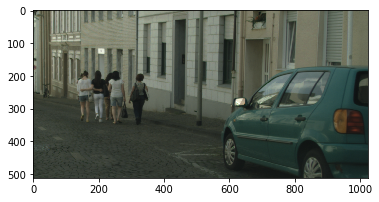

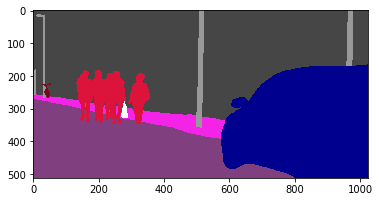

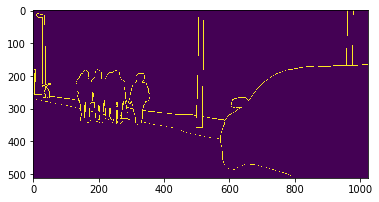

In [5]:
img,label,mask=train_dataset[1500]
showimage(img,1)
plt.imshow(train_dataset.decode_segmap(label.numpy()))
plt.show()
plt.imshow(mask.numpy())
plt.show()

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=2)
validation_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1)

In [7]:
unet=Unet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
unet=unet.to(device)
#optimizer=SGD(unet.parameters(),lr=6*10**(-4))
#optimizer=SGD(unet.parameters(),lr=10**(-4),momentum=0.99,weight_decay=0.0005)
optimizer=Adam(unet.parameters())

cuda


In [8]:
def FocalLoss(input_image, target, masks,gamma=2):
    n,c,h,w=input_image.size()
    nt,ht,wt=target_image.size()
    
    if (h!=ht and w!=wt):
        input_image=F.interpolate(input_image, size=(ht, wt), mode="bilinear", align_corners=True)
    
    input_image=input_image.transpose(1,2).transpose(2,3).contiguous()
    target_image[target_image==255]=19
    for i in range(target_image.size(0)):
        mask=masks[i]
        #eps=10**(-12)
        #counts=torch.bincount(target_image[i].view(-1))
        #counts=torch.sum(counts)/(counts.float()+eps)
        #print(counts.size())
        
        #alpha=torch.tensor([counts[j] for j in target_image[i].view(-1)]).type(torch.cuda.FloatTensor)
        #print(alpha.size())
        
        if i==0:
            logpt=F.cross_entropy(input_image[i].view(-1,c),target_image[i].view(-1),reduction='none')
            pt=torch.exp(-logpt)
            loss=((((1-pt)**gamma)*logpt*mask.view(-1))).mean()
        else:
            logpt=F.cross_entropy(input_image[i].view(-1,c),target_image[i].view(-1),reduction='none')
            pt=torch.exp(-logpt)
            loss+=((((1-pt)**gamma)* logpt*mask.view(-1))).mean()
    
    return loss

In [9]:
def train(input_image,target_image,masks,optimizer):
    unet.train()
    optimizer.zero_grad()
    output_image=unet(input_image)
    loss=FocalLoss(output_image[:,0:20,:,:],target_image,masks)
    #print(loss.size())
    loss.backward()
    optimizer.step()
    return loss.item()

In [10]:
def val_loss_function(output_model,target):
    n,c,h,w=output_model.size()
    nt,ht,wt=target.size()
    
    if (h!=ht and w!=wt):
        output_model=F.interpolate(output_model, size=(ht, wt), mode="bilinear", align_corners=True)
        
    output_model=F.softmax(output_model.squeeze(0),dim=0).transpose(0,1).transpose(1,2)
    predicted=np.zeros((ht,wt))
    target=target.squeeze(0).cpu().numpy().reshape(-1)
    output_model=output_model.cpu().numpy()
    predicted=np.argmax(output_model,axis=2)
    predicted=predicted.reshape(-1)
    target[target==255]=19
    score=jss(target,predicted)
    return score

In [11]:
def validation(input_image,target_image):
    with torch.no_grad():
        unet.eval()
        output_image=unet(input_image)
        loss=val_loss_function(output_image[:,0:20,:,:],target_image)
        return loss

In [12]:
checkpoint = torch.load('saved/model_21.pth')
unet.load_state_dict(checkpoint['model_state_dict'])
batch = checkpoint['epoch']
tl = checkpoint['tl']
vl = checkpoint['vl']
unet.train()

Unet(
  (conv1a): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1b): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2b): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Sequential(
    (0): Conv2d(128,

In [ ]:
#tl=[]
#vl=[]
benchmark=np.amax(vl)
for batch in range(4,10):
    running_loss=0
    for i,inputs in enumerate(train_loader):
        #if(np.random.random()>0.5):
         #   input_image=Variable(torch.flip(inputs[0],dims=[-1])).to(device)
         #   target_image=(torch.flip(inputs[1],dims=[-1])).to(device)
        #else:
        input_image=Variable(inputs[0]).to(device)
        target_image=Variable(inputs[1]).to(device)
        masks=Variable(inputs[2]).to(device)
        #print(target_image[0])
        #break
        loss=train(input_image,target_image,masks,optimizer)
        running_loss+=loss
        tl.append(loss)
        if (i+1)%93==0:
            loss_val=0
            for j,inputs in enumerate(validation_loader):
                input_image=(inputs[0]).to(device)
                target_image=(inputs[1]).to(device)
                loss_val+=validation(input_image,target_image)
            loss_val=loss_val/(j+1)
            vl.append(loss_val)
            print ('Step: {} | Batch: {} | Training loss: {} | Validation IoU: {}'.format(int((i+1)/93), batch+1, running_loss, loss_val))
            running_loss=0
            if(loss_val>benchmark):
                print('%--Saving the model--%')
                torch.save({
                    'step':int((i+1)/93),
                    'epoch': batch+1,
                    'model_state_dict': unet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'tl': tl,
                    'vl': vl
                    }, 'saved/model_21.pth')
                benchmark=loss_val
            
            

Step: 1 | Batch: 5 | Training loss: 170.5171743631363 | Validation IoU: 0.554388542175293
Step: 2 | Batch: 5 | Training loss: 164.69266682863235 | Validation IoU: 0.6024133110046387
Step: 3 | Batch: 5 | Training loss: 158.9517304301262 | Validation IoU: 0.6074585838317871
Step: 4 | Batch: 5 | Training loss: 169.29352343082428 | Validation IoU: 0.6232422370910644
Step: 5 | Batch: 5 | Training loss: 162.8184117078781 | Validation IoU: 0.6011621589660645
Step: 6 | Batch: 5 | Training loss: 161.7939848303795 | Validation IoU: 0.5887368392944335
Step: 7 | Batch: 5 | Training loss: 163.94621360301971 | Validation IoU: 0.6175390243530273
Step: 8 | Batch: 5 | Training loss: 163.50438261032104 | Validation IoU: 0.5516904220581055
Step: 9 | Batch: 5 | Training loss: 172.95973825454712 | Validation IoU: 0.5846016426086426
Step: 10 | Batch: 5 | Training loss: 168.72278183698654 | Validation IoU: 0.5980972366333008
Step: 11 | Batch: 5 | Training loss: 172.62609630823135 | Validation IoU: 0.59629607

In [13]:
np.amax(vl)

0.7916796760559082

In [14]:
batch

18